In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import seaborn as sns

In [ ]:
df = pd.read_csv('contract.csv')

df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = df['EndDate'].replace('No', np.nan)
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BeginYear'] = df['BeginDate'].dt.year
df['BeginMonth'] = df['BeginDate'].dt.month
df['BeginDay'] = df['BeginDate'].dt.day
df['EndYear'] = df['EndDate'].dt.year
df['EndMonth'] = df['EndDate'].dt.month
df['EndDay'] = df['EndDate'].dt.day

In [ ]:
df['quit'] = df['EndDate'].apply(lambda x: x is not pd.NaT)
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,BeginYear,BeginMonth,BeginDay,EndYear,EndMonth,EndDay,quit
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,1,NaN,NaN,NaN,False
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5,2017,4,1,NaN,NaN,NaN,False
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,1,2019.0,12.0,1.0,True
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,1,NaN,NaN,NaN,False
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,1,2019.0,11.0,1.0,True


In [ ]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(np.float64)
df = df.dropna(subset='TotalCharges')
df = df.assign(Subscriptions = lambda x: np.int64(np.floor(x['TotalCharges'].astype(np.float64) / x['MonthlyCharges'].astype(np.float64))))
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,BeginYear,BeginMonth,BeginDay,EndYear,EndMonth,EndDay,quit,Subscriptions
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,1,NaN,NaN,NaN,False,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,2017,4,1,NaN,NaN,NaN,False,33
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,1,2019.0,12.0,1.0,True,2
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,1,NaN,NaN,NaN,False,43
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,1,2019.0,11.0,1.0,True,2


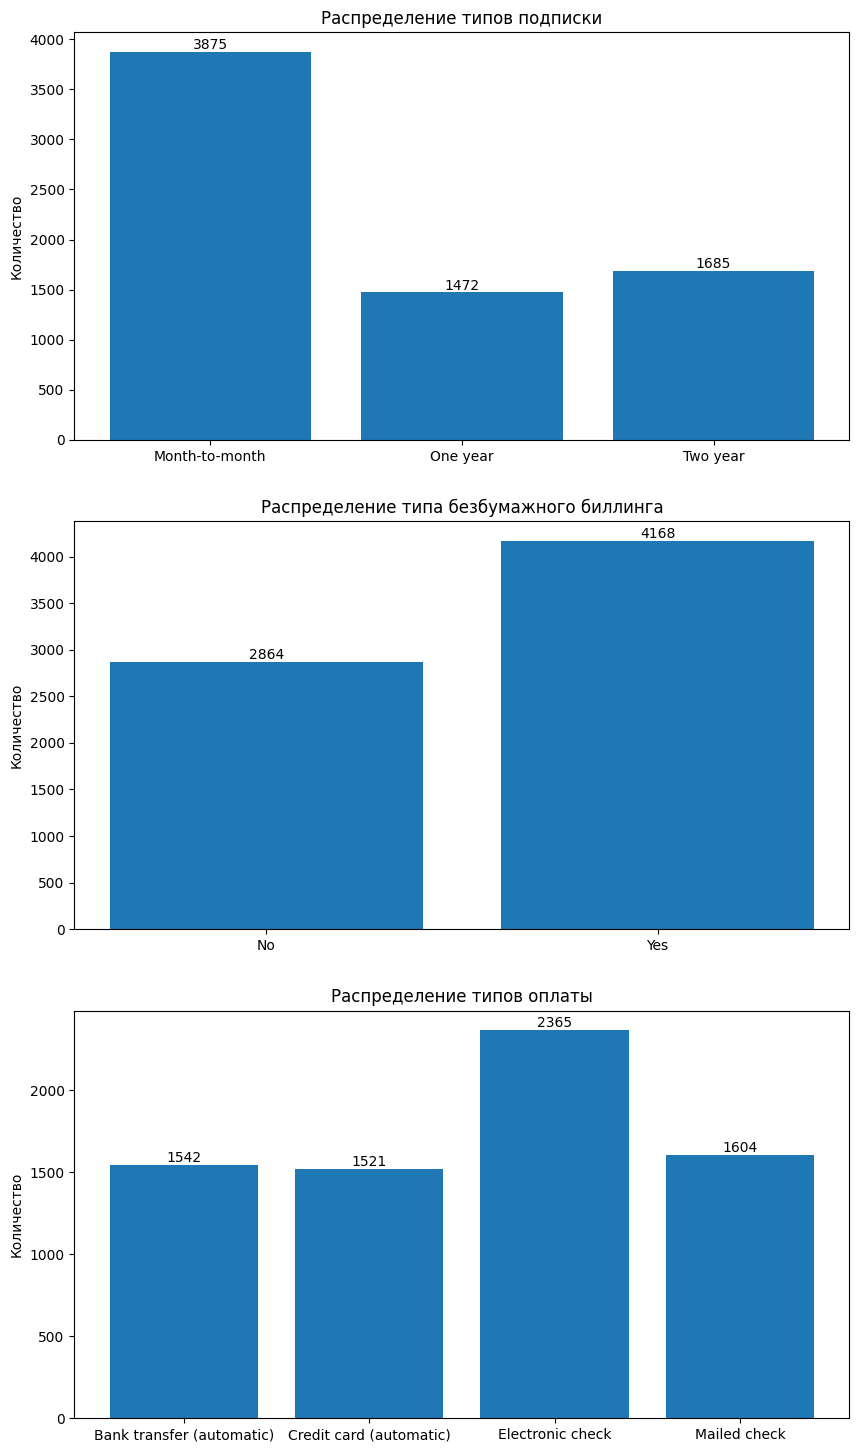

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,18))

types = df.groupby('Type')[['customerID']].count().reset_index()
ax1 = axs[0].bar(types['Type'], types['customerID'])
axs[0].bar_label(ax1)
axs[0].set_ylabel('Количество')
axs[0].set_title('Распределение типов подписки')

billing = df.groupby('PaperlessBilling')[['customerID']].count().reset_index()
ax2 = axs[1].bar(billing['PaperlessBilling'], billing['customerID'])
axs[1].bar_label(ax2)
axs[1].set_ylabel('Количество')
axs[1].set_title('Распределение типа безбумажного биллинга')

method = df.groupby('PaymentMethod')[['customerID']].count().reset_index()
ax3 = axs[2].bar(method['PaymentMethod'], method['customerID'])
axs[2].bar_label(ax3)
axs[2].set_ylabel('Количество')
axs[2].set_title('Распределение типов оплаты')

plt.show()

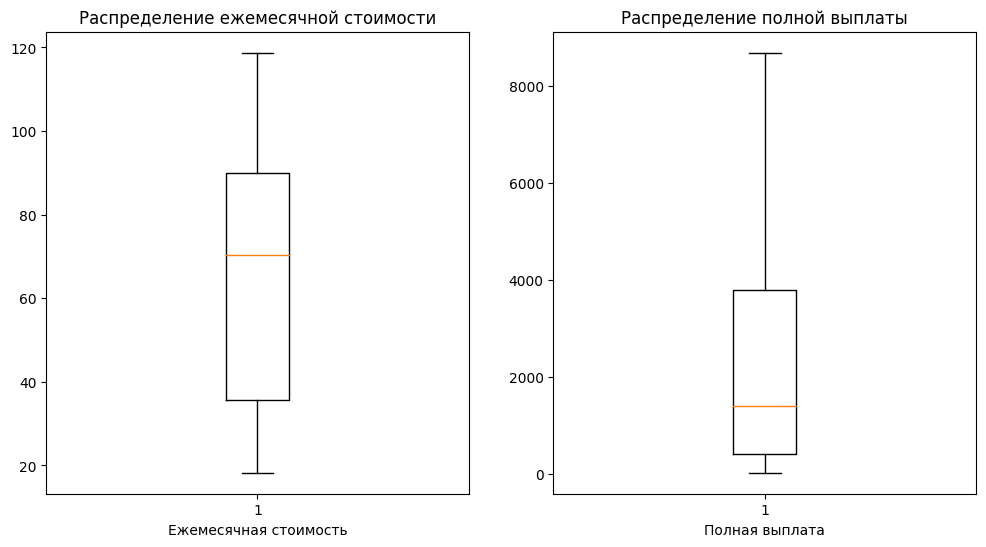

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax1 = axs[0].boxplot(df['MonthlyCharges'])
axs[0].set_title('Распределение ежемесячной стоимости')
axs[0].set_xlabel('Ежемесячная стоимость')

ax2 = axs[1].boxplot(df['TotalCharges'])
axs[1].set_title('Распределение полной выплаты')
axs[1].set_xlabel('Полная выплата')

plt.show()

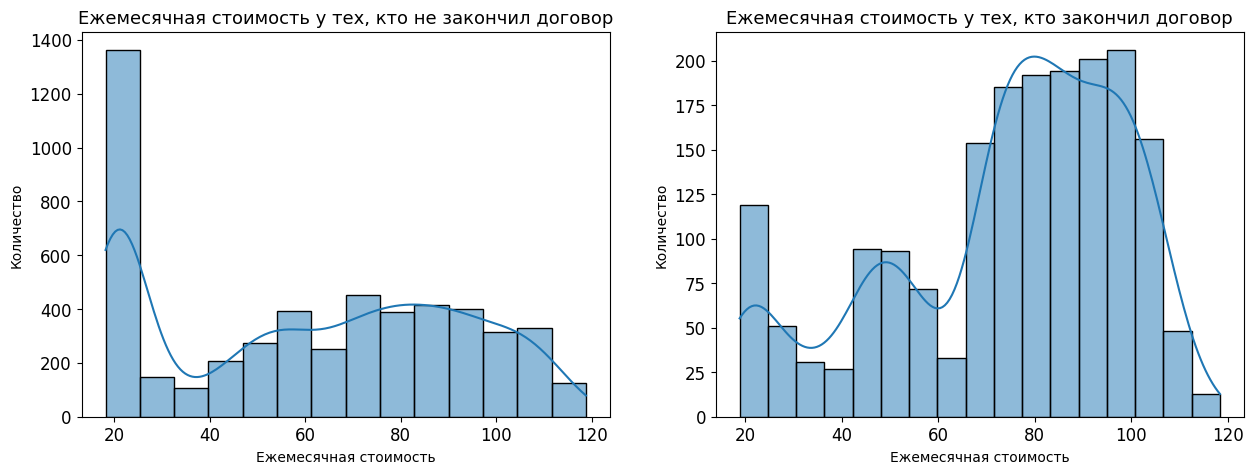

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax1 = sns.histplot(data=df[df['quit'] == 0], x="MonthlyCharges", ax=axes[0], kde=True)
ax1.set_title('Ежемесячная стоимость у тех, кто не закончил договор', fontsize=13)
ax1.set_xlabel('Ежемесячная стоимость')
ax1.set_ylabel('Количество')
ax1.tick_params(labelsize=12)

ax2 = sns.histplot(data=df[df['quit'] == 1], x="MonthlyCharges", ax=axes[1], kde=True)
ax2.set_title('Ежемесячная стоимость у тех, кто закончил договор', fontsize=13)
ax2.set_xlabel('Ежемесячная стоимость')
ax2.set_ylabel('Количество')
ax2.tick_params(labelsize=12)

plt.show()

In [ ]:
model = RandomForestClassifier()

features = df.drop(columns=['quit', 'BeginDate', 'BeginYear', 'BeginMonth', 'BeginDay', 'EndDate', 'EndYear', 'EndMonth', 'EndDay', 'customerID'])
features = pd.get_dummies(features, columns=['Type', 'PaperlessBilling', 'PaymentMethod'])
target = df['quit']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

model.fit(x_train, y_train)

pred = model.predict(x_test)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.84      0.85      0.85      1059
        True       0.53      0.52      0.53       348

    accuracy                           0.77      1407
   macro avg       0.69      0.68      0.69      1407
weighted avg       0.77      0.77      0.77      1407



<Axes: >

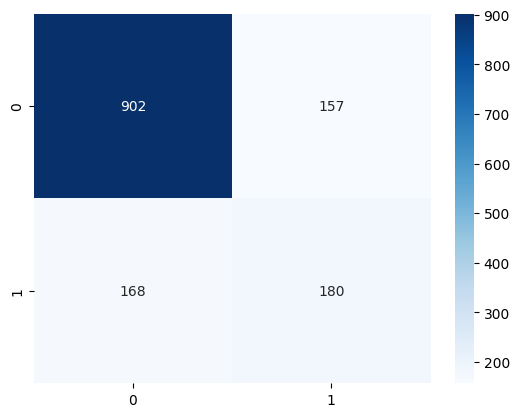

In [ ]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues', fmt='g')

In [ ]:
importances = pd.Series(model.feature_importances_, index=x_train.columns)

importances = importances.sort_values()
importances

,0
PaymentMethod_Bank transfer (automatic),0.007201
PaymentMethod_Credit card (automatic),0.007785
PaymentMethod_Mailed check,0.008748
PaperlessBilling_No,0.012323
Type_One year,0.012628
PaperlessBilling_Yes,0.012862
Type_Two year,0.027883
PaymentMethod_Electronic check,0.032664
Type_Month-to-month,0.074649
Subscriptions,0.200412


<Axes: >

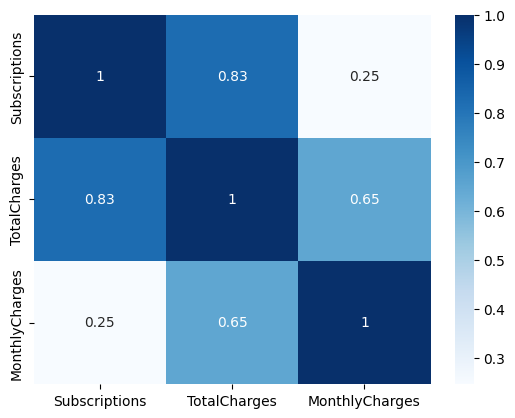

In [ ]:
df2 = df[['Subscriptions', 'TotalCharges', 'MonthlyCharges']]
sns.heatmap(df2.corr(), annot=True, cmap='Blues')

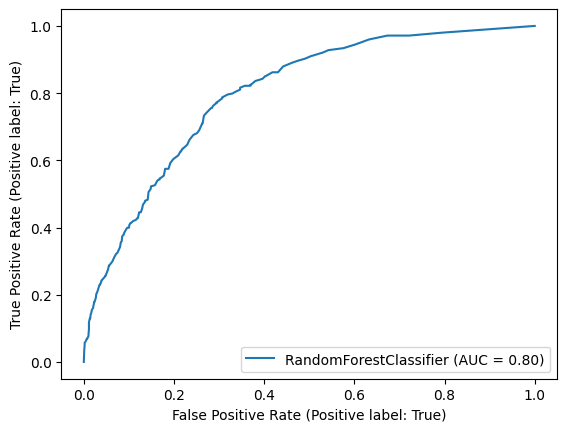

In [ ]:
curve = RocCurveDisplay.from_estimator(model, x_test, y_test)
curve